https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#<br>
https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset

# Credit Card Default
August 13, 2019<br>Ngoc, ETL & EDA

-----------------------------------------------------------------

In this notebook, we will perform:
- data cleaning,
- exploratory data analysis, and
- feature engineering

in order to be ready for the modeling step.

----------------------------------------------

# Import

In [56]:
%matplotlib inline

import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime

sns.set_style("whitegrid")
warnings.filterwarnings("ignore", category=FutureWarning)

Change directory to get data source code:

In [57]:
main_path = os.getcwd()
parent_path = Path(os.getcwd()).parent
src_path = str(parent_path) + "/src/directories"
os.chdir(src_path)

More import:

In [58]:
import change_directory

Change back to notebook directory:

In [59]:
os.chdir(main_path)

# ETL

## Load data

Change directory to get data:

In [60]:
cd = change_directory.ChangeDirectory()

In [61]:
cd.change_to_data_dir()

Load data:

In [62]:
ccd_df = pd.read_excel("raw/default of credit card clients.xls", header=1)

Change back to notebook directory:

In [63]:
cd.change_to_notebook_dir()

## Explore data

Quick peek into the data:

In [64]:
ccd_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [65]:
ccd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6               

No missing data.

Duplicates?

In [66]:
sum(ccd_df.duplicated())

0

Good.

### default payment next month
Default Payment: ```Yes = 1``` & ```No = 0```.<br>This is our response variable.

In [67]:
ccd_df["default payment next month"].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64

There is a modest class imbalance. We will try over-sampling, under-sampling, and SMOTE. We will try algorithms which often perform well on imbalanced datasets (decision tree algorithms like C4.5, C5.0, CART, and/or Random Forest, etc.).

Change variable's name to DEFAULT:

In [68]:
ccd_df.rename(columns={"default payment next month": "DEFAULT"}, inplace=True)

### ID
ID of each client.

In [69]:
ccd_df.ID.nunique()

30000

In [70]:
ccd_df.ID.head()

0    1
1    2
2    3
3    4
4    5
Name: ID, dtype: int64

In [71]:
ccd_df.ID.tail()

29995    29996
29996    29997
29997    29998
29998    29999
29999    30000
Name: ID, dtype: int64

Just indexing. We don't need it.

In [72]:
ccd_df.drop("ID", axis=1, inplace=True)

### LIMIT_BAL
Amount of the given credit (NT dollar): includes both the individual consumer credit and his/her family (supplementary) credit.

In [73]:
ccd_df.LIMIT_BAL.describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

Text(0,0.5,'Count')

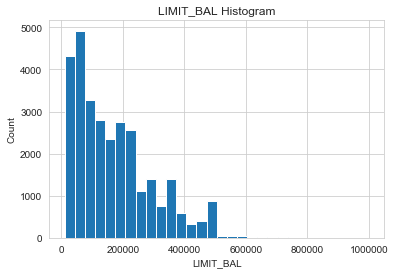

In [74]:
ccd_df.LIMIT_BAL.hist(bins=30)
plt.title("LIMIT_BAL Histogram")
plt.xlabel("LIMIT_BAL")
plt.ylabel("Count")

Not normally distributed.

Text(0.5,1,'LIMIT_BAL Box Plot')

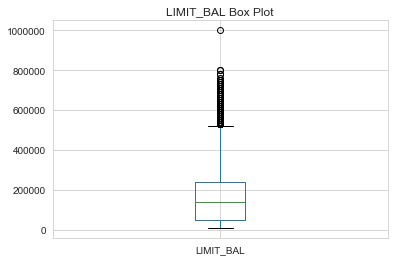

In [75]:
ccd_df.LIMIT_BAL.plot.box()
plt.title("LIMIT_BAL Box Plot")

Quite a few outliers.

Versus DEFAULT:

Text(0,0.5,'DEFAULT')

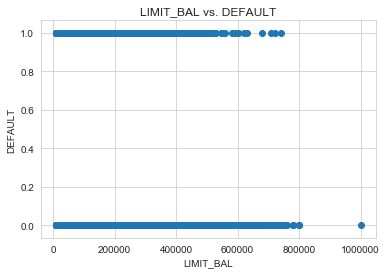

In [76]:
plt.scatter(ccd_df.LIMIT_BAL, ccd_df.DEFAULT)
plt.title("LIMIT_BAL vs. DEFAULT")
plt.xlabel("LIMIT_BAL")
plt.ylabel("DEFAULT")

In [77]:
ccd_df.LIMIT_BAL.corr(ccd_df.DEFAULT, method="spearman")

-0.16958627777128973

No clear relationship.

### SEX
Gender: ```Male = 1``` & ```Female = 2```.

In [78]:
ccd_df.SEX.value_counts(sort=False)

1    11888
2    18112
Name: SEX, dtype: int64

In [79]:
ccd_df.SEX.value_counts(sort=False, normalize=True)

1    0.396267
2    0.603733
Name: SEX, dtype: float64

Versus DEFAULT:

In [80]:
pd.crosstab(ccd_df.SEX, ccd_df.DEFAULT)

DEFAULT,0,1
SEX,,
1,9015,2873
2,14349,3763


In [81]:
pd.crosstab(ccd_df.SEX, ccd_df.DEFAULT, normalize="index")

DEFAULT,0,1
SEX,,
1,0.758328,0.241672
2,0.792237,0.207763


Males tend to default slightly more than females.

Dummy:

In [82]:
sex_dummies = pd.get_dummies(ccd_df.SEX, prefix="SEX", drop_first=True)
ccd_df = pd.concat([ccd_df, sex_dummies], axis=1)
ccd_df.drop("SEX", axis=1, inplace=True)

Change variable's name to FEMALE:

In [83]:
ccd_df.rename(columns={"SEX_2": "FEMALE"}, inplace=True)

### EDUCATION
Education: ```Unknown = 0```, ```Graduate School = 1```, ```University = 2```, ```High School = 3```, ```Others = 4```, ```Unknown = 5```, & ```Unknown = 6```.

In [84]:
ccd_df.EDUCATION.value_counts(sort=False)

0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: EDUCATION, dtype: int64

In [85]:
ccd_df.EDUCATION.value_counts(sort=False, normalize=True)

0    0.000467
1    0.352833
2    0.467667
3    0.163900
4    0.004100
5    0.009333
6    0.001700
Name: EDUCATION, dtype: float64

Versus DEFAULT:

In [86]:
pd.crosstab(ccd_df.EDUCATION, ccd_df.DEFAULT)

DEFAULT,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


In [87]:
pd.crosstab(ccd_df.EDUCATION, ccd_df.DEFAULT, normalize="index")

DEFAULT,0,1
EDUCATION,,
0,1.000000,0.000000
1,0.807652,0.192348
2,0.762651,0.237349
3,0.748424,0.251576
4,0.943089,0.056911
5,0.935714,0.064286
6,0.843137,0.156863


High school graduates tend to default slightly more than others.

Dummy:

In [88]:
education_dummies = pd.get_dummies(ccd_df.EDUCATION, prefix="EDUCATION", drop_first=True)
ccd_df = pd.concat([ccd_df, education_dummies], axis=1)
ccd_df.drop("EDUCATION", axis=1, inplace=True)

Change variables' names:

In [89]:
ccd_df.rename(columns={"EDUCATION_1": "GRADUATE_SCHOOL", "EDUCATION_2": "UNIVERSITY",
                       "EDUCATION_3": "HIGH_SCHOOL", "EDUCATION_4": "EDUCATION_OTHERS",
                       "EDUCATION_5": "EDUCATION_UNKNOWN_1", "EDUCATION_6": "EDUCATION_UNKNOWN_2"}, inplace=True)

### MARRIAGE
Marital Status: ```Unknown = 0```, ```Married = 1```, ```Single = 2```, & ```Others = 3```.

In [90]:
ccd_df.MARRIAGE.value_counts(sort=False)

0       54
1    13659
2    15964
3      323
Name: MARRIAGE, dtype: int64

In [91]:
ccd_df.MARRIAGE.value_counts(sort=False, normalize=True)

0    0.001800
1    0.455300
2    0.532133
3    0.010767
Name: MARRIAGE, dtype: float64

Versus DEFAULT:

In [92]:
pd.crosstab(ccd_df.MARRIAGE, ccd_df.DEFAULT)

DEFAULT,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


In [93]:
pd.crosstab(ccd_df.MARRIAGE, ccd_df.DEFAULT, normalize="index")

DEFAULT,0,1
MARRIAGE,,
0,0.907407,0.092593
1,0.765283,0.234717
2,0.790717,0.209283
3,0.739938,0.260062


Married people tend to default slightly more than single people.

Dummy:

In [94]:
marriage_dummies = pd.get_dummies(ccd_df.MARRIAGE, prefix="MARRIAGE", drop_first=True)
ccd_df = pd.concat([ccd_df, marriage_dummies], axis=1)
ccd_df.drop("MARRIAGE", axis=1, inplace=True)

Change variables' names:

In [95]:
ccd_df.rename(columns={"MARRIAGE_1": "MARRIED", "MARRIAGE_2": "SINGLE",
                       "MARRIAGE_3": "MARRIAGE_OTHERS"}, inplace=True)

### AGE
Age in years.

In [96]:
ccd_df.AGE.describe()

count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

Text(0,0.5,'Count')

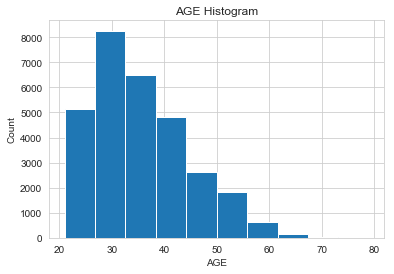

In [97]:
ccd_df.AGE.hist()
plt.title("AGE Histogram")
plt.xlabel("AGE")
plt.ylabel("Count")

Not normally distributed.

Text(0.5,1,'AGE Box Plot')

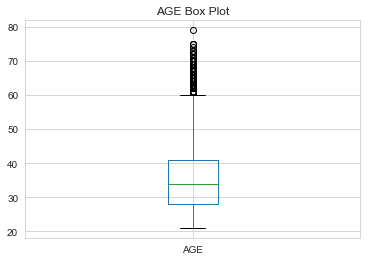

In [98]:
ccd_df.AGE.plot.box()
plt.title("AGE Box Plot")

Quite a few outliers.

Versus DEFAULT:

Text(0,0.5,'DEFAULT')

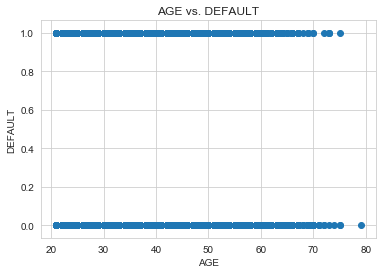

In [99]:
plt.scatter(ccd_df.AGE, ccd_df.DEFAULT)
plt.title("AGE vs. DEFAULT")
plt.xlabel("AGE")
plt.ylabel("DEFAULT")

In [100]:
ccd_df.AGE.corr(ccd_df.DEFAULT, method="spearman")

0.005148863519844661

No clear relationship.

### PAY_0
Repayment status in September, 2005.<br>
The measurement scale for the repayment status is: ```Pay Duly = -1```, ```Payment Delay for One Month = 1```, ```Payment Delay for Two Months = 2```, ..., ```Payment Delay for Eight Months = 8```, ```Payment Delay for Nine Months and Above = 9```.

In [101]:
ccd_df.PAY_0.value_counts(sort=False)

 0    14737
 1     3688
 2     2667
 3      322
 4       76
 5       26
 6       11
 7        9
 8       19
-2     2759
-1     5686
Name: PAY_0, dtype: int64

In [102]:
payment_history_dummies = pd.get_dummies(ccd_df.PAY_0.astype('category'), prefix='Payment_history_Sept')
ccd_df = pd.concat([ccd_df, payment_history_dummies], axis=1)
ccd_df.drop('PAY_0', axis=1, inplace=True)

In [106]:
for col in ['PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
    ccd_df[col] = ccd_df[col].astype('category')
ccd_df.dtypes

LIMIT_BAL                     int64
AGE                           int64
PAY_2                      category
PAY_3                      category
PAY_4                      category
PAY_5                      category
PAY_6                      category
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
DEFAULT                       int64
FEMALE                        uint8
GRADUATE_SCHOOL               uint8
UNIVERSITY                    uint8
HIGH_SCHOOL                   uint8
EDUCATION_OTHERS              uint8
EDUCATION_UNKNOWN_1           uint8
EDUCATION_UNKNOWN_2           uint8
MARRIED                     

In [109]:
payment_hist_prefixes = {'PAY_2':"Payment_history_Aug",
                         'PAY_3':'Payment_hist_Jul',
                         'PAY_4':'Payment_hist_Jun',
                         'PAY_5':'Payment_hist_May',
                         'PAY_6':'Payment_hist_Apr'}
ccd_df = pd.get_dummies(ccd_df, prefix=payment_hist_prefixes)

In [121]:
rename_cols = {"BILL_AMT1": "Bill_amount_Sep",
               "BILL_AMT2":"Bill_amount_Aug",
               "BILL_AMT3":"Bill_amount_Jul",
               "BILL_AMT4":"Bill_amount_Jun",
               "BILL_AMT5":"Bill_amount_May",
               "BILL_AMT6":"Bill_amount_Apr",
               "PAY_AMT1":"Bill_amount_Sep",
               "PAY_AMT2":"Bill_amount_Aug",
               "PAY_AMT3":"Bill_amount_Jul",
               "PAY_AMT4":"Bill_amount_Jun",
               "PAY_AMT5":"Bill_amount_May",
               "PAY_AMT6":"Bill_amount_Apr",}
ccd_df.rename(rename_cols, inplace=True, axis=1)
ccd_df.columns

Index(['LIMIT_BAL', 'AGE', 'Bill_amount_Sep', 'Bill_amount_Aug',
       'Bill_amount_Jul', 'Bill_amount_Jun', 'Bill_amount_May',
       'Bill_amount_Apr', 'Bill_amount_Sep', 'Bill_amount_Aug',
       'Bill_amount_Jul', 'Bill_amount_Jun', 'Bill_amount_May',
       'Bill_amount_Apr', 'DEFAULT', 'FEMALE', 'GRADUATE_SCHOOL', 'UNIVERSITY',
       'HIGH_SCHOOL', 'EDUCATION_OTHERS', 'EDUCATION_UNKNOWN_1',
       'EDUCATION_UNKNOWN_2', 'MARRIED', 'SINGLE', 'MARRIAGE_OTHERS',
       'Payment_history_Sept_-2', 'Payment_history_Sept_-1',
       'Payment_history_Sept_0', 'Payment_history_Sept_1',
       'Payment_history_Sept_2', 'Payment_history_Sept_3',
       'Payment_history_Sept_4', 'Payment_history_Sept_5',
       'Payment_history_Sept_6', 'Payment_history_Sept_7',
       'Payment_history_Sept_8', 'Payment_history_Aug_-2',
       'Payment_history_Aug_-1', 'Payment_history_Aug_0',
       'Payment_history_Aug_1', 'Payment_history_Aug_2',
       'Payment_history_Aug_3', 'Payment_history_Aug_4',


## Processed data

In [122]:
processed = ccd_df.copy()
processed.shape

(30000, 89)

Change directory to save data:

In [123]:
cd = change_directory.ChangeDirectory()
cd.change_to_data_dir()

Save data:

In [124]:
processed.to_csv("processed/processed_credit_card_defaults.csv", index=False)

Change back to notebook directory:

In [125]:
cd.change_to_notebook_dir()